In [1]:
import sys
import math
import itertools
from pathlib import Path
from typing import Callable, Tuple

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Add parent directory to path
sys.path.append(str(Path("..").resolve()))

from data_handling import (
    load_measurements_npz,
    MeasurementDataset,
    MeasurementLoader
)

# 2. Import modularized code
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve

# Define paths
data_dir = Path("measurements")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Data resides in: {data_dir.resolve()}")

Running on: cpu
Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4_mod/measurements


In [2]:
def compute_mz_abs(samples: torch.Tensor) -> Tuple[float, float]:
    """Computes average absolute Z-magnetization."""
    # Convert samples (0/1) to spins (+1/-1)
    spins_pm = 1.0 - 2.0 * samples.float()
    mz_per_sample = spins_pm.mean(dim=1)
    mz_abs = mz_per_sample.abs()

    total_mz = mz_abs.mean().item()
    total_mz_err = mz_abs.std(unbiased=True).item() / math.sqrt(samples.shape[0])
    return total_mz, total_mz_err

def compute_mx(samples: torch.Tensor, log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> Tuple[float, float]:
    """Computes X-magnetization using the ratio estimator."""
    B, N = samples.shape
    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)
        total_ratios = torch.zeros(B, device=samples.device, dtype=torch.float32)

        # iterate over all sites and compute flip ratios
        for i in range(N):
            flipped_samples = samples.clone()
            flipped_samples[:, i] = 1 - flipped_samples[:, i]
            log_scores_flip = log_score_fn(flipped_samples)
            log_ratios = log_scores_flip - log_scores_orig
            total_ratios += torch.exp(log_ratios)

        avg_mx_per_sample = total_ratios / N
        total_mx = avg_mx_per_sample.mean().item()
        total_mx_err = avg_mx_per_sample.std(unbiased=True).item() / math.sqrt(B)
        return total_mx, total_mx_err

In [3]:
SIDE_LENGTH = 4
TRAIN_SAMPLES = 20_000
FILE_SAMPLES = 20_000

# Support list
h_support = [1.00, 1.50, 2.10, 2.80, 3.00, 3.30, 3.60, 4.00, 5.00, 6.00, 7.00]

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLES}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

# Verify existence
missing = [fp for fp in file_paths if not fp.exists()]
if missing:
    print(f"Warning: {len(missing)} files missing. Check generation.")

print(f"System Size       : {SIDE_LENGTH}x{SIDE_LENGTH}")
print(f"Training Samples  : {TRAIN_SAMPLES} per file")
print(f"Support Fields (h): {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=[TRAIN_SAMPLES]*len(file_paths))

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 4x4
Training Samples  : 20000 per file
Support Fields (h): [1.0, 1.5, 2.1, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]
Samples Shape     : (220000, 16)
Conditions Shape  : (220000, 1)


In [4]:
# TRAINING CONFIG
batch_size        = 1024
num_visible       = ds.num_qubits
num_hidden        = 64
conditioner_width = 64
num_epochs        = 50
k_steps           = 10

init_lr           = 1e-2
final_lr          = 1e-4

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator(device=device).manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

# Instantiate Model (SymmetricHyperRBM)
# New class signature: num_v, num_h, hyper_dim, k
model = SymmetricHyperRBM(
    num_v=num_visible,
    num_h=num_hidden,
    hyper_dim=conditioner_width,
    k=k_steps
).to(device)

# V2 initialization (std=0.01) is handled automatically in __init__

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.005)

# Train using module function
model = train_loop(
    model=model,
    optimizer=optimizer,
    loader=loader,
    num_epochs=num_epochs,
    lr_schedule_fn=lr_schedule_fn,
    noise_frac=0.1,
    rng=rng
)

Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0318     | 0.010000
10     | +0.0039     | 0.010000
20     | +0.0065     | 0.009955
30     | -0.0018     | 0.000146
40     | -0.0053     | 0.000100
50     | -0.0032     | 0.000100


In [6]:
# EVALUATION CONFIG
h_novel = [1.8, 2.4, 2.6, 2.9, 3.1, 3.4, 3.8, 4.5, 5.5, 6.5]
sweep = sorted([(h, "support") for h in h_support] + [(h, "novel") for h in h_novel], key=lambda x: x[0])

eval_samples = 10_000
eval_steps = 100
rng_eval = torch.Generator(device=device).manual_seed(1234)

print("=== EVALUATION SWEEP ===")
results = []

# Constant temperature schedule (T=1.0) for standard sampling
# We call this variable 'schedule_tensor' to differentiate from the argument name
schedule_tensor = torch.tensor([1.0] * eval_steps, device=device, dtype=torch.float32)

for h_val, kind in sweep:
    # Prepare condition batch
    # The new generate() infers n_samples from the batch size of the condition
    cond_batch = torch.full((eval_samples, 1), h_val, device=device, dtype=torch.float32)

    # Generate samples
    # FIX: Argument name is 'T_schedule', not 'schedule'
    samples = model.generate(cond_batch, T_schedule=schedule_tensor, rng=rng_eval)

    # Scorer wrapper for Mx calculation
    # Mx computation requires log_score, which requires matching batch sizes
    scorer = lambda v: model.log_score(v, cond_batch)

    mz, _ = compute_mz_abs(samples)
    mx, _ = compute_mx(samples, scorer)

    results.append({"h": h_val, "type": kind, "mz": mz, "mx": mx})
    print(f"h {h_val:5.2f} [{kind:7}] | |Mz|: {mz:.5f} | Mx: {mx:.5f}")

df = pd.DataFrame(results).sort_values("h")

=== EVALUATION SWEEP ===
h  1.00 [support] | |Mz|: 0.96705 | Mx: 0.25372
h  1.50 [support] | |Mz|: 0.91950 | Mx: 0.39064
h  1.80 [novel  ] | |Mz|: 0.88396 | Mx: 0.46001
h  2.10 [support] | |Mz|: 0.82235 | Mx: 0.55515
h  2.40 [novel  ] | |Mz|: 0.71842 | Mx: 0.67368
h  2.60 [novel  ] | |Mz|: 0.63176 | Mx: 0.75210
h  2.80 [support] | |Mz|: 0.55154 | Mx: 0.81550
h  2.90 [novel  ] | |Mz|: 0.51551 | Mx: 0.83868
h  3.00 [support] | |Mz|: 0.47905 | Mx: 0.86383
h  3.10 [novel  ] | |Mz|: 0.44960 | Mx: 0.88110
h  3.30 [support] | |Mz|: 0.39658 | Mx: 0.91165
h  3.40 [novel  ] | |Mz|: 0.37901 | Mx: 0.92200
h  3.60 [support] | |Mz|: 0.34601 | Mx: 0.93799
h  3.80 [novel  ] | |Mz|: 0.32408 | Mx: 0.94826
h  4.00 [support] | |Mz|: 0.30955 | Mx: 0.95517
h  4.50 [novel  ] | |Mz|: 0.28650 | Mx: 0.96842
h  5.00 [support] | |Mz|: 0.26910 | Mx: 0.97377
h  5.50 [novel  ] | |Mz|: 0.25864 | Mx: 0.97990
h  6.00 [support] | |Mz|: 0.25027 | Mx: 0.98360
h  6.50 [novel  ] | |Mz|: 0.24180 | Mx: 0.98615
h  7.00 [suppor

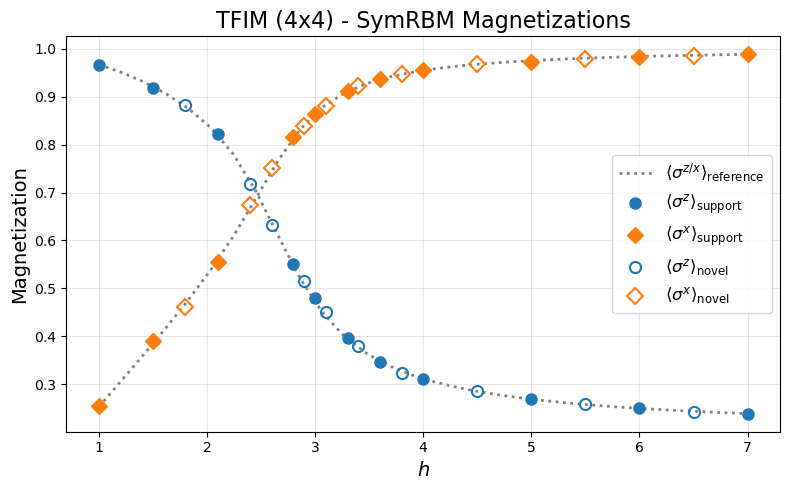

In [7]:
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

supp = df[df["type"] == "support"]
nov = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5))

if ref_df is not None:
    plt.plot(ref_df["h"], ref_df["mag_z"], ':', color='gray', linewidth=2.0, label='_nolegend_', zorder=1)
    plt.plot(ref_df["h"], ref_df["mag_x"], ':', color='gray', linewidth=2.0,
             label=r'$\langle \sigma^{z/x} \rangle_{\mathrm{reference}}$', zorder=1)

plt.plot(supp["h"], supp["mz"], 'o', color='C0', markersize=8,
         label=r'$\langle \sigma^z \rangle_{\mathrm{support}}$', zorder=2)
plt.plot(supp["h"], supp["mx"], 'D', color='C1', markersize=8,
         label=r'$\langle \sigma^x \rangle_{\mathrm{support}}$', zorder=2)

plt.plot(nov["h"], nov["mz"], 'o', color='C0', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^z \rangle_{\mathrm{novel}}$', zorder=2)
plt.plot(nov["h"], nov["mx"], 'D', color='C1', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^x \rangle_{\mathrm{novel}}$', zorder=2)

plt.xlabel(r'$h$', fontsize=14)
plt.ylabel('Magnetization', fontsize=14)
plt.title(f"TFIM ({SIDE_LENGTH}x{SIDE_LENGTH}) - SymRBM Magnetizations", fontsize=16)

plt.legend(frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
import time
timestamp = time.strftime("%Y%m%d_%H%M%S")

file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_hyper_rbm_{timestamp}.csv"
df.to_csv(file_name, index=False, float_format="%.6f")
print(f"\nSaved RBM magnetizations to: {Path(file_name).resolve()}")


Saved RBM magnetizations to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4_mod/tfim_4x4_magnet_hyper_rbm_20260114_212616.csv
